<a href="https://colab.research.google.com/github/ghostfm3/ksks/blob/master/CBOW01R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null
!echo mecab-config --dicdir"/mecab-ipadic-neologd"

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
mecab-config --dicdir/mecab-ipadic-neologd


In [2]:
pip install unidic-lite

     |████████████████████████████████| 47.3MB 68kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.7-cp36-none-any.whl size=47556593 sha256=7102b9e8ccc8019e6f312e7de1ea93d8589198f75fc60f912467782469385fba
  Stored in directory: /root/.cache/pip/wheels/a8/82/7d/086724645e33a575aafd0b1dae2835c37d2c00c6a0a96ee3a0
Successfully built unidic-lite


| epoch 1 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 21 |  iter 1 / 1 | ti

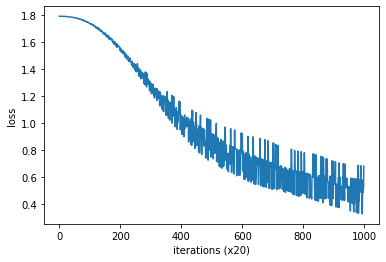

In [7]:
import numpy
import numpy as np
import sys
sys.path.append('..')
import time
import matplotlib.pyplot as plt
import os
import MeCab
# coding: utf-8

GPU = False


if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np



def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

class MatMul:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None
  
  def forward(self, x):
    W, = self.params
    out = np.dot(x, W)
    self.x = x
    return out
  
  def backward(self, dout):
    W, = self.params
    dx = np.dot(dout, W.T)
    dw = np.dot(self.x.T, dout)
    self.grads[0][...] = dw
    return dx

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
    
    self.word_vecs = W_in

  def forward(self, contexts, target):
   h0 = self.in_layer0.forward(contexts[:, 0])
   h1 = self.in_layer1.forward(contexts[:, 1])
   h = (h0 + h1) * 0.5
   score = self.out_layer.forward(h)
   loss = self.loss_layer.forward(score, target)
   return loss

  def backward(self, dout=1):
   ds = self.loss_layer.backward(dout)
   da = self.out_layer.backward(ds)
   da *= 0.5
   self.in_layer1.backward(da)
   self.in_layer0.backward(da)
   return None

def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
     new_id = len(word_to_id)
     word_to_id[word] = new_id
     id_to_word[new_id] = word 
  
  corpus = np.array([word_to_id[w] for w in words])
  return corpus, word_to_id, id_to_word


def create_context_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
      cs.append(corpus[idx + t])
    contexts.append(cs)
  
  return np.array(contexts), np.array(target)


def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

def wakati(text):
    tagger = MeCab.Tagger('')
    tagger.parse('') 
    node = tagger.parseToNode(text)
    word_list = []
     
    while node:
        pos = node.feature.split(",")[0]
        #品詞を選択
        if pos in ["名詞","動詞","助詞","形容詞","代名詞"]: 
            word = node.surface
            word_list.append(word)
        node = node.next
         
    return " ".join(word_list)


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

#m = MeCab.Tagger('-Owakati')
#result = m.parse("PPIとはプロトンポンプ阻害薬のことです")

text1 = '吾輩は猫である。名前はまだ無い。'
text = wakati(text1)

corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_context_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [8]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

吾輩 [-0.79368585 -0.87433636  1.1989415   0.7962664   0.8913672 ]
は [ 0.84324574 -0.9417155   0.81018406 -0.8307079  -0.86325336]
猫 [-0.8340586  -0.74397266 -0.61626256  0.8065594   0.5672396 ]
ある [ 0.8460804  -0.9315375   0.82701117 -0.85572886 -0.86349624]
名前 [-0.83283365 -0.7256028  -0.60309255  0.8214178   0.5452407 ]
無い [-0.7797827 -0.8452963  1.1804411  0.7833503  0.8952109]
